In [37]:
import numpy as np
import sys
import os
import torch
import wandb

import itertools

# Define the path to the parent project folder
project_path = r'C:/Users/palig/MSE/Vertiefungsprojekt1/mse_vp1_rulestimation'

# Add the path to sys.path if it does not already exist
if project_path not in sys.path:
    sys.path.append(project_path)

from torch import optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from models.lstm import LSTMModel
from utils.preprocess import CMAPSS_Dataset
from utils.train import Trainer

# Configure device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

data_path = os.path.join(project_path, 'data', 'final')
save_path = os.path.join(project_path, 'models', 'trained_models')
model_path = os.path.join(project_path, 'models')
result_path = os.path.join(project_path, 'data', 'results')

model_results = {}

In [38]:
api = wandb.Api()

project_name = "mse-vp1"
entity = "p-alig-fh-ost"

In [39]:
subset = '13'
max_rul = 125
seq_length = 30

config={
    "learning_rate": 0.001,
    "epochs": 500,
    "model": f"LSTM_{subset}"
    }

Training of group 1 (DF1 and DF3)

In [5]:
trainset = CMAPSS_Dataset(
    mode = 'train',
    data_path=data_path,
    subset=subset,
    seq_length=seq_length,
    max_rul=max_rul
)

train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(dataset=train_subset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_subset, batch_size=64, shuffle=False, num_workers=0)

# Training

iterations = 2
best_score_list = []
best_RMSE_list = []
for iteration in range(iterations):
    global_step = 0
    run = wandb.init(
        project=project_name,
        name=f"LSTM_{subset}-iteration_{iteration}",
        config=config,
        reinit=True   # Wichtig! Startet WandB für jede Iteration neu
    )
    model = LSTMModel()
    print('Model loaded')
    optimizer = optim.Adam(model.parameters(), lr=run.config["learning_rate"])
    epochs = run.config["epochs"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    trainer = Trainer(model=model,
                        model_optimizer=optimizer,
                        print_every=50,
                        epochs=epochs,
                        device=device,
                        prefix=subset,
                        handcrafted=False
                        )
    best_score, best_RMSE, global_step = trainer.train(train_loader, val_loader, iteration, global_step)
    best_score_list.append(best_score)
    best_RMSE_list.append(best_RMSE)
    if iteration == np.argmin(best_RMSE_list):
        torch.save(model.state_dict(), os.path.join(save_path, f'{run.config["model"]}_best.pth'))
        print(f"Best model saved at iteration {iteration + 1}.")

    run.finish()

best_score_list = np.array(best_score_list)
best_RMSE_list = np.array(best_RMSE_list)

result = np.concatenate((best_score_list, best_RMSE_list)).reshape(2, iterations)
print(result)


Found 200 unique motor IDs in the data set.


wandb: Currently logged in as: p-alig (p-alig-fh-ost). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Model loaded
cuda
Epoch: 1
test result: score: 0.6076293137052119, RMSE: 0.14111499938242308
Epoch: 2
test result: score: 0.5505626034818005, RMSE: 0.1264988102883889
best_score_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration1_best_RMSE.pth.tar!
Epoch: 3
test result: score: 0.5082006656088339, RMSE: 0.12108945862334575
best_score_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration1_best_RMSE.pth.tar!
Epoch: 4
test result: score: 0.49727653135558386, RMSE: 0.12468031505371908
best_score_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration1_best_score.pth.tar!
Epoch: 5
test result: score: 0.46272632129694746, RMSE: 0.11533031271499426
best_score_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration1_best_score.pth.tar!
best

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇█
epoch/train-RMSE,█▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
epoch/train-loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-RMSE,██▇▆▇▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▄▁▁
epoch/val-loss,█▆▅▄▅▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-score,█▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/RMSE,▆▆█▅▅▅▄▄▄▇▅▂▅▃▃▃▂▃▃▄▂▂▃▁▂▂▂▂▂▂▂▂▃▂▁▁▂▂▂▁
train/loss,▇▄▄█▇▆█▄▄▃▆▄▃▅▃▃▂▂▂▃▂▂▂▂▂▁▃▂▁▁▁▁▂▁▁▁▂▁▁▁
validation/RMSE,██▇▇▇▇▇▇▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation/RMSE_rul,██▇▇▇▇▇▇▇▆▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁
validation/loss,▇█▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Model loaded
cuda
Epoch: 1
test result: score: 0.5862453846243717, RMSE: 0.15080451174050627
Epoch: 2
test result: score: 0.5087714408927072, RMSE: 0.13187359851161454
best_score_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration2_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration2_best_RMSE.pth.tar!
Epoch: 3
test result: score: 0.5302218678868265, RMSE: 0.12429648627336344
best_RMSE_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration2_best_RMSE.pth.tar!
Epoch: 4
test result: score: 0.49148416690949376, RMSE: 0.12017251362141691
best_score_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration2_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration2_best_RMSE.pth.tar!
Epoch: 5
test result: score: 0.46473918270332415, RMSE: 0.1195416427716881
best_score_checkpoints saved successfully at ./checkpoints/LSTM_13/13_iteration2_best_score.pth.tar!
best_R

epoch/epoch,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇████
epoch/train-RMSE,██▆▆▆▆▆▅▅▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁
epoch/train-loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-RMSE,██▇▆▅▅▅▅▄▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch/val-loss,█▆▆▆▆▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
epoch/val-score,█▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▁▂▁▁▁
train/RMSE,█▄▇█▇▄▆▆▅▃▄▂▂▄▄▃▃▂▃▃▂▃▂▄▂▂▂▃▂▂▁▂▂▂▃▃▂▂▃▂
train/loss,▆▅▃█▃▄▃▆▃▅▅▂▃▅▁▂▁▂▂▃▁▂▁▂▂▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁
validation/RMSE,█▇▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁
validation/RMSE_rul,█▇▆▆▆▆▆▆▅▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
validation/loss,█▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁


[[0.07672748 0.08617616]
 [0.02147561 0.02399283]]


✔️ Last completed run: w81b3vj7


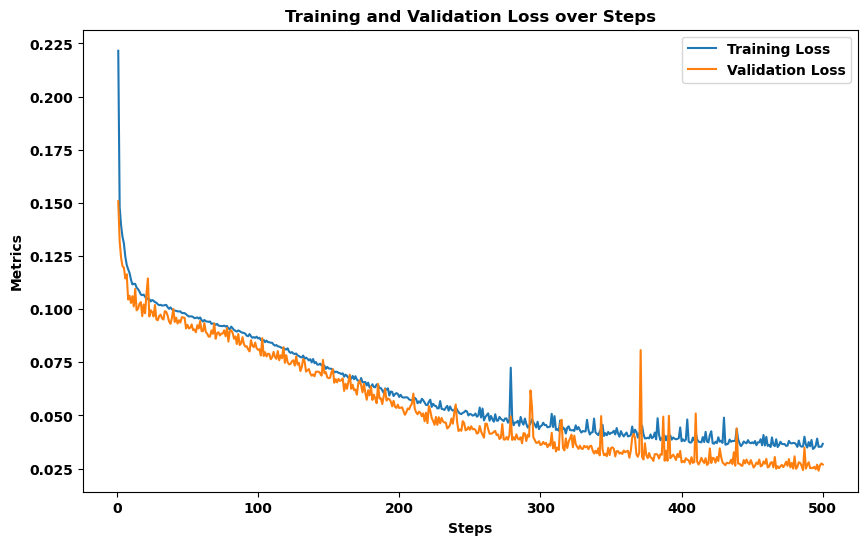

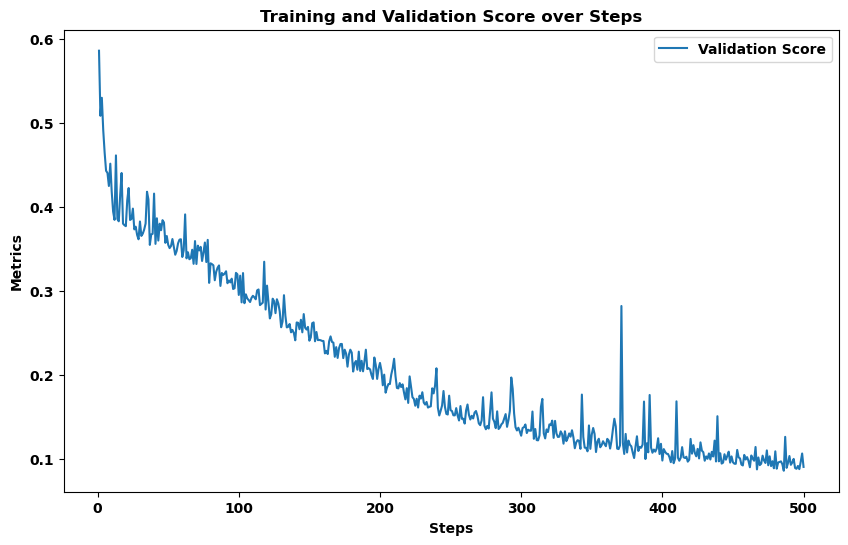

In [6]:
api = wandb.Api()

# Retrieve all runs
runs = api.runs(f"{entity}/{project_name}")

# Sort by end time (stop time) and filter only completed runs
finished_runs = [run for run in runs if run.state == "finished"]

if not finished_runs:
    print("❌ No completed run found!")
else:
    last_run = sorted(finished_runs, key=lambda r: r.created_at, reverse=True)[0]
    print("✔️ Last completed run:", last_run.id)

    run = api.run(f"{entity}/{project_name}/{last_run.id}")

history = run.history()

train_rmse = history["epoch/train-RMSE"]
val_rmse = history["epoch/val-RMSE"]
val_score = history["epoch/val-score"]

steps = range(len(history["_step"].values))

plt.figure(figsize=(10, 6))
plt.plot(steps, train_rmse, label="Training Loss")
plt.plot(steps, val_rmse, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, val_score, label="Validation Score")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Score over Steps")
plt.legend()
plt.show()

Predictions of group 1 (DF1 and DF3)

In [42]:
from sklearn.metrics import mean_squared_error

# Modell initialisieren und gespeicherte Gewichte laden
model = LSTMModel()
model.load_state_dict(torch.load(os.path.join(save_path, f'{config["model"]}_best.pth')))
model = model.to(device)
model.eval()  # Modell in den Evaluierungsmodus setzen

testset = CMAPSS_Dataset(
    mode = 'test',
    data_path=data_path,
    subset=subset,
    seq_length=seq_length,
    max_rul=max_rul
)
test_loader = DataLoader(dataset=testset, batch_size=1000, shuffle=False, num_workers=0)

all_predictions_13 = []
all_labels_13 = []

# Testdaten auswerten
with torch.no_grad():
    for data in test_loader:
        X, _, y = data
        X, y = X.to(device), y.to(device)

        predictions = model(X)

        # Verarbeite die Vorhersagen (z. B. Speichern oder Auswerten)
        pred_batch = predictions.squeeze().detach().cpu().numpy() * max_rul
        labels_batch = y.squeeze().detach().cpu().numpy() * max_rul

        # Sammle alle Vorhersagen und Labels
        all_predictions_13.extend(pred_batch)
        all_labels_13.extend(labels_batch)

# Konvertiere die Listen in NumPy-Arrays
all_predictions_13 = np.array(all_predictions_13)
all_labels_13 = np.array(all_labels_13)

rmse_13 = np.sqrt(mean_squared_error(all_labels_13, all_predictions_13))
print(f'RMSE: {rmse_13:.3f}')

score_13 = Trainer.score(torch.tensor(all_labels_13), torch.tensor(all_predictions_13))
print(f'Score: {score_13:.3f}')

# Save predictions
model_results["LSTM_13"] = {
    "predictions": all_predictions_13,
    "labels": all_labels_13,
    "rmse": rmse_13,
    "score": score_13  
}

Found 200 unique motor IDs in the data set.
RMSE: 16.045
Score: 1401.156


In [43]:
subset = '24'
max_rul = 125
seq_length = 30

config={
    "learning_rate": 0.001,
    "epochs": 700,
    "model": f"LSTM_{subset}"
    }

Training of group 2 (DF2 and DF4)

In [9]:
trainset = CMAPSS_Dataset(
    mode = 'train',
    data_path=data_path,
    subset=subset,
    seq_length=seq_length,
    max_rul=max_rul
)


train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(dataset=train_subset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset=val_subset, batch_size=64, shuffle=False, num_workers=0)

# Training
iterations = 2
best_score_list = []
best_RMSE_list = []
for iteration in range(iterations):
    global_step = 0
    run = wandb.init(
        project=project_name,
        name=f"LSTM_{subset}",
        config=config,
        reinit=True   # Wichtig! Startet WandB für jede Iteration neu
    )
    model = LSTMModel()
    print('Model loaded')
    optimizer = optim.Adam(model.parameters(), lr=run.config["learning_rate"])
    epochs = run.config["epochs"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    trainer = Trainer(model=model,
                        model_optimizer=optimizer,
                        print_every=50,
                        epochs=epochs,
                        device=device,
                        prefix=subset,
                        handcrafted=False
                        )
    best_score, best_RMSE, global_step = trainer.train(train_loader, val_loader, iteration, global_step)
    best_score_list.append(best_score)
    best_RMSE_list.append(best_RMSE)
    if iteration == np.argmin(best_RMSE_list):
        torch.save(model.state_dict(), os.path.join(save_path, f'{run.config["model"]}_best.pth'))
        print(f"Best model saved at iteration {iteration + 1}.")

    run.finish()

best_score_list = np.array(best_score_list)
best_RMSE_list = np.array(best_RMSE_list)

result = np.concatenate((best_score_list, best_RMSE_list)).reshape(2, iterations)
print(result)


Found 509 unique motor IDs in the data set.


Model loaded
cuda
Epoch: 1
test result: score: 1.2342827893968236, RMSE: 0.2692445286000524
Epoch: 2
test result: score: 0.9923146513988846, RMSE: 0.2476687049808287
best_score_checkpoints saved successfully at ./checkpoints/LSTM_24/24_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/LSTM_24/24_iteration1_best_RMSE.pth.tar!
Epoch: 3
test result: score: 0.7908717864647767, RMSE: 0.1787543765182754
best_score_checkpoints saved successfully at ./checkpoints/LSTM_24/24_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/LSTM_24/24_iteration1_best_RMSE.pth.tar!
Epoch: 4
test result: score: 0.9031284987837299, RMSE: 0.23156668217932241
Epoch: 5
test result: score: 0.7170430445849449, RMSE: 0.15887644130415232
best_score_checkpoints saved successfully at ./checkpoints/LSTM_24/24_iteration1_best_score.pth.tar!
best_RMSE_checkpoints saved successfully at ./checkpoints/LSTM_24/24_iteration1_best_RMSE.pth.tar!
Epoch: 6
t

epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███████
epoch/train-RMSE,█▇▇▆▅▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/train-loss,█▆▆▅▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-RMSE,█▅▅▅▅▄▃▃▃▂▃▂▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch/val-loss,█▆▇▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-score,█▆▄▄▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/RMSE,▇█▄▆▃▄▃▂▂▂▃▃▂▂▂▁▃▂▂▁▃▂▂▁▂▂▃▁▂▂▂▂▂▂▃▂▂▂▃▃
train/loss,█▆▂▂▃▁▂▂▁▁▁▃▁▁▁▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▁▁▂▁
validation/RMSE,██▆▅▅▃▃▂▃▂▂▂▂▃▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/RMSE_rul,█▆▅▅▄▃▃▃▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▂
validation/loss,█▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


Model loaded
cuda
Epoch: 1
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 2
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 3
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 4
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 5
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 6
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 7
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 8
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 9
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 10
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 11
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 12
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 13
test result: score: 3.462492063907614, RMSE: 0.7585852458435083
Epoch: 14
test result: score:

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
epoch/train-RMSE,████▆▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/train-loss,████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-RMSE,███▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-loss,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val-score,████▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/RMSE,▇▇█▂▃▂▂▂▂▂▂▃▂▁▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/RMSE,█████▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/RMSE_rul,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/loss,████▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


[[0.12108621 0.16224636]
 [0.03276484 0.04383251]]


✔️ Last completed run: o9l04e0c


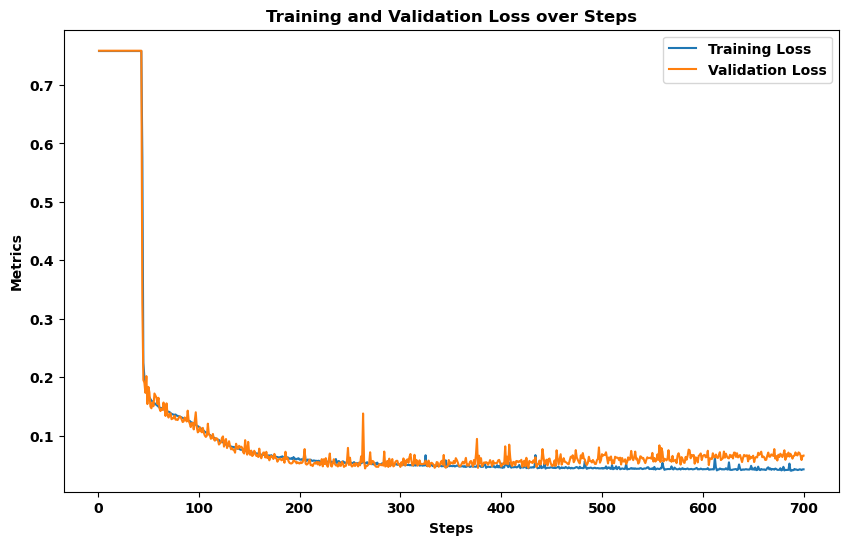

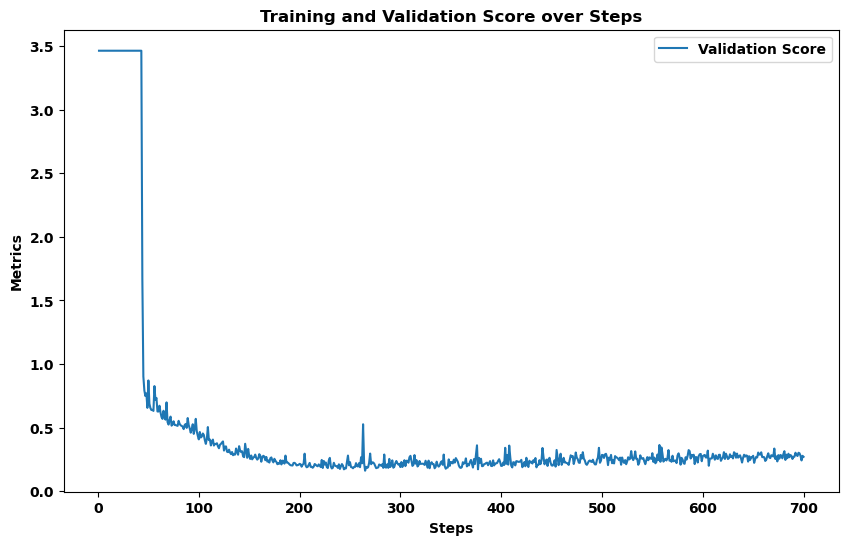

In [10]:
api = wandb.Api()

# Retrieve all runs
runs = api.runs(f"{entity}/{project_name}")

# Sort by end time (stop time) and filter only completed runs
finished_runs = [run for run in runs if run.state == "finished"]

if not finished_runs:
    print("❌ No completed run found!")
else:
    last_run = sorted(finished_runs, key=lambda r: r.created_at, reverse=True)[0]
    print("✔️ Last completed run:", last_run.id)

    run = api.run(f"{entity}/{project_name}/{last_run.id}")

history = run.history()

train_rmse = history["epoch/train-RMSE"]
val_rmse = history["epoch/val-RMSE"]
val_score = history["epoch/val-score"]

steps = range(len(history["_step"].values))

plt.figure(figsize=(10, 6))
plt.plot(steps, train_rmse, label="Training Loss")
plt.plot(steps, val_rmse, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Loss over Steps")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, val_score, label="Validation Score")
plt.xlabel("Steps")
plt.ylabel("Metrics")
plt.title("Training and Validation Score over Steps")
plt.legend()
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error

# Modell initialisieren und gespeicherte Gewichte laden
model = LSTMModel()
model.load_state_dict(torch.load(os.path.join(save_path, f'{config["model"]}_best.pth')))
model = model.to(device)
model.eval()  # Modell in den Evaluierungsmodus setzen

testset = CMAPSS_Dataset(
    mode = 'test',
    data_path=data_path,
    subset=subset,
    seq_length=seq_length,
    max_rul=max_rul
)
test_loader = DataLoader(dataset=testset, batch_size=1000, shuffle=False, num_workers=0)

all_predictions_24 = []
all_labels_24 = []

# Testdaten auswerten
with torch.no_grad():
    for data in test_loader:
        X, _, y = data
        X, y = X.to(device), y.to(device)

        predictions = model(X)

        # Verarbeite die Vorhersagen (z. B. Speichern oder Auswerten)
        pred_batch = predictions.squeeze().detach().cpu().numpy() * max_rul
        labels_batch = y.squeeze().detach().cpu().numpy() * max_rul

        # Sammle alle Vorhersagen und Labels
        all_predictions_24.extend(pred_batch)
        all_labels_24.extend(labels_batch)

# Konvertiere die Listen in NumPy-Arrays
all_predictions_24 = np.array(all_predictions_24)
all_labels_24 = np.array(all_labels_24)

rmse_24 = np.sqrt(mean_squared_error(all_labels_24, all_predictions_24))
print(f'RMSE: {rmse_24:.3f}')

score_24 = Trainer.score(torch.tensor(all_labels_24), torch.tensor(all_predictions_24))
print(f'Score: {score_24:.3f}')

# Save predictions
model_results["LSTM_24"] = {
    "predictions": all_predictions_24,
    "labels": all_labels_24,
    "rmse": rmse_24,
    "score": score_24   
}

Found 507 unique motor IDs in the data set.
RMSE: 19.237
Score: 9419.647


In [50]:
import pandas as pd
from sklearn.metrics import f1_score, mean_squared_error

rul_score = Trainer.score

load_path = os.path.join(data_path, 'ids.txt')
arrays = {}
current_key = None

with open(load_path, 'r') as file:
    for line in file:
        line = line.strip()
        if line.startswith("id"):
            current_key = line.replace(":", "")
            arrays[current_key] = []
        elif current_key and line:
            arrays[current_key].extend(map(int, line.split()))

# Konvertieren in NumPy-Arrays
id_train_13 = np.array(arrays["id_train13"])
id_train_24 = np.array(arrays["id_train24"])
id_test_13 = np.array(arrays["id_test13"])
id_test_24 = np.array(arrays["id_test24"])

print("Array1:", id_train_13.shape)
print("Array2:", id_train_24.shape)
print("Array3:", id_test_13.shape)
print("Array4:", id_test_24.shape)


def merge_pred_id(ids, predictions):
    if len(ids) != len(predictions):
        raise ValueError("IDs und Predictions müssen die gleiche Länge haben.")

    combined = np.column_stack((ids, predictions))
    return combined

print(f'Pred13: {len(all_predictions_13)} -- IDs13: {len(id_test_13)}')
print(f'Pred24: {len(all_predictions_24)} -- IDs13: {len(id_test_24)}')

predictions13 = merge_pred_id(id_test_13, all_predictions_13)
predictions24 = merge_pred_id(id_test_24, all_predictions_24)

combined = np.vstack((predictions13, predictions24))
predicted_rul = combined[np.argsort(combined[:, 0])]
rul_true = rul = np.loadtxt(os.path.join(data_path, 'RUL_test.txt'), dtype=np.float32)
rul_true = np.minimum(rul_true, 125)

rmse = np.sqrt(mean_squared_error(rul_true, predicted_rul[:,1]))
print(f'RMSE: {rmse:.1f}')

score = rul_score(torch.tensor(rul_true), torch.tensor(predicted_rul[:,1]))
print(f'RUL-Score: {score:.0f}')

predicted_labels = predicted_rul.copy()
predicted_labels[:,1] = (predicted_rul[:,1] <= 100).astype(int)
true_labels = (rul_true <= 100).astype(int)

F1_score = f1_score(true_labels, predicted_labels[:,1])
print(f'F1 Score: {F1_score:.3f}')

df_result = pd.DataFrame(predicted_labels, columns=['engine_no', 'result'], dtype=int)
display(df_result)
model_name = 'LSTM'
# Speichern als CSV-Datei
csv_file_path = os.path.join(result_path, f'results_{model_name}.csv')
df_result.to_csv(csv_file_path, index=False)

# Save predictions
model_results["LSTM"] = {
    "predictions": predicted_rul[:,1],
    "labels": rul_true,
    "rmse": rmse,
    "score": score,
    "f1_score": F1_score
}

Array1: (200,)
Array2: (509,)
Array3: (200,)
Array4: (507,)
Pred13: 200 -- IDs13: 200
Pred24: 507 -- IDs13: 507
RMSE: 18.4
RUL-Score: 10821
F1 Score: 0.879


,engine_no,result
0,0,1
1,1,1
2,2,0
3,3,1
4,4,1
...,...,...
702,702,1
703,703,0
704,704,1
705,705,1


In [51]:
file_path = os.path.join(result_path, "LSTM_predictions.npz")
np.savez(file_path, model_results=model_results)